In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests
import pickle as pkl
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

## Regionalización (Clustering)

En Calvetti, et. al. (2020) argumentan que considerar a los $\beta r_k$ se debe a que cada patch debe tener densidades diferentes y por ello la dinámica de contactos debe ser diferente. Dada la densidad de un municipio y su ubicación, queremos agruparlos en $k$ regiones de tal forma que los municipios de la misma región "se parezcan".

Vamos a concatenar las tres tablas de viajes:

En el archivo shp tenemos datos sobre las poblaciones de los municipios. Vamos a usar esos datos para el proceso de clustering:

In [5]:
filepath = "D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/miZMVMmap/miZMVM.shp"
# leemos el mapa de todos los municipios de MX
data_ZMVM = gpd.read_file(filepath, encoding = 'latin')

In [89]:
mapa_ZMVM = data_ZMVM[['cve_umun', 'geometry']]

Obtenemos los centroides

In [7]:
data_ZMVM.insert(4, 'x', data_ZMVM['geometry'].centroid.x)
data_ZMVM.insert(5, 'y', data_ZMVM['geometry'].centroid.y)

Vamos a usar la ubicación de los municipios y su población de 2020

In [11]:
cols = ['cve_umun', 'x', 'y']
censo = data_ZMVM.loc[:, cols]
censo.set_index('cve_umun', inplace=True)

In [12]:
censo.head()

,x,y
cve_umun,,
09012,-99.206221,19.198340
09013,-99.090364,19.245145
09008,-99.268413,19.268977
09015,-99.149056,19.431373
09010,-99.246820,19.336176


In [13]:
pob = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_miZMVM.csv", index_col = 0,
                 dtype = {'cve_umun':str})
pob.head()

,pop
cve_umun,
09002,432205
09003,614447
09004,217686
09005,1173351
09006,404695


Para encontrar la densidad de los municipios necesitamos el área de la superficie correspondiente:

In [16]:
url = 'https://es.wikipedia.org/wiki/Zona_metropolitana_del_valle_de_M%C3%A9xico'
html = requests.get(url).content
df_list = pd.read_html(html)
# primer tabla de la página
wiki_df = df_list[1]

In [17]:
wiki_df.set_index(0, inplace = True)

In [18]:
sup = wiki_df.iloc[1:, 7].astype(float)

### Conteo de CETRAMS

Teorizamos que los municipios con cetrams deben ser algunos de los que mayores contactos tienen:

In [211]:
cetrams = gpd.read_file("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/rawdata/ubicaciones transporte/cetram_shp")

In [94]:
def isin(point):
    for i, polygon in enumerate(mapa_ZMVM['geometry']):
        if polygon.contains(point):
            return mapa_ZMVM.iloc[i, 0]

In [212]:
cetrams['cve_umun'] = cetrams['geometry'].apply(isin)

In [213]:
cntcetrams = cetrams.groupby(['cve_umun']).size()

### Conteo estaciones de Metro

In [208]:
metro = gpd.read_file("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/rawdata/ubicaciones transporte/stcmetro_shp")

In [209]:
metro['cve_umun'] = metro['geometry'].apply(isin)

In [149]:
cntmetro = metro.groupby(['cve_umun']).size()

Las coordenadas de los archivos del MB están mal, así que sacamos los pares alcaldías-cves.

In [220]:
parAlcCve = metro[['ALCALDIAS', 'cve_umun']]

In [236]:
pares = parAlcCve.groupby('ALCALDIAS').first().to_dict()['cve_umun']

In [246]:
pares['Tlalpan'] = '09012'
pares['Xochimilco'] = '09013'

### Conteo estaciones de MB

In [216]:
mb = gpd.read_file("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/rawdata/ubicaciones transporte/mb_shp/Metrobus_estaciones_utm14n.shp")

In [247]:
def apares(x):
    try:
        return pares[x]
    except:
        muns = x.split(' / ')
        return pares[muns[0]]
        

In [248]:
mb['cve_umun'] = mb['ALCALDIAS'].apply(apares)

In [250]:
cntmb = mb.groupby(['cve_umun']).size()

### Formación de DataFrame

Creamos el data frame con la info de cada municipio:

In [384]:
df = pd.concat([censo, pob, sup], join = 'inner', axis = 1)
df.rename(columns = {8:'sup'}, inplace = True)

In [385]:
df = pd.concat([df, cntcetrams], join = 'outer', axis = 1)
df.fillna(0, inplace = True)
df.rename(columns = {0:'cntcetrams'}, inplace = True)

In [368]:
#df = pd.concat([df, cntmetro], join = 'outer', axis = 1)
#df.fillna(0, inplace = True)
#df.rename(columns = {0:'cntmetro'}, inplace = True)

In [341]:
#df = pd.concat([df, cntmb], join = 'outer', axis = 1)
#df.fillna(0, inplace = True)
#df.rename(columns = {0:'cntmb'}, inplace = True)

Calculamos la densidad

In [386]:
df['densidad'] = df['pop']/df['sup']

In [387]:
df.drop(['sup'], axis = 1, inplace = True); # ya no necesitamos la población

In [388]:
df.head()

,x,y,pop,cntcetrams,densidad
09012,-99.206221,19.198340,699928,1.0,2225.526232
09013,-99.090364,19.245145,442178,2.0,3875.354952
09008,-99.268413,19.268977,247622,0.0,3905.709779
09015,-99.149056,19.431373,545884,3.0,16796.430769
09010,-99.246820,19.336176,759137,3.0,7915.922836


Le agregamos las personas que entran entre semana:

In [345]:
M = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_entre_semana_por_cve_umun_2020.csv", 
               index_col = 0, dtype = {'origen':str})

In [346]:
entradas = M.sum(axis = 0)

In [389]:
df = pd.concat([df, entradas], join = 'inner', axis = 1)
df.rename(columns = {0:'entradas'}, inplace = True)

In [397]:
df

,x,y,pop,cntcetrams,densidad,entradas
09012,-99.206221,19.198340,699928,1.0,2225.526232,1273631
09013,-99.090364,19.245145,442178,2.0,3875.354952,841072
09008,-99.268413,19.268977,247622,0.0,3905.709779,554963
09015,-99.149056,19.431373,545884,3.0,16796.430769,1936820
09010,-99.246820,19.336176,759137,3.0,7915.922836,1091236
09002,-99.182107,19.485329,432205,2.0,12901.641791,571205
09014,-99.161135,19.380642,434153,2.0,16260.411985,890794
09005,-99.115864,19.504065,1173351,7.0,13348.703072,1582050
09004,-99.310729,19.324634,217686,0.0,3044.559441,638838
09016,-99.204567,19.428062,414470,2.0,8932.543103,1288533


### K-means clustering

Dado un número $k$ de clusters y datos $x\in \mathbb R^n$, buscamos $\mu_1,...,\mu_k\in \mathbb R^n$ centroides y $S_1,...,S_k$ clusters tales que se minimice la suma de cuadrados en los clusters (WCSS):

$$\sum_{i=1}^k \sum_{x\in S_i} ||x-\mu_i||^2 $$

Debemos normalizar todos los datos para que ninguna columna tenga más peso que otra:

In [390]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

Veamos cómo se mejora la función objetivo respecto al número de clusters:

In [391]:
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

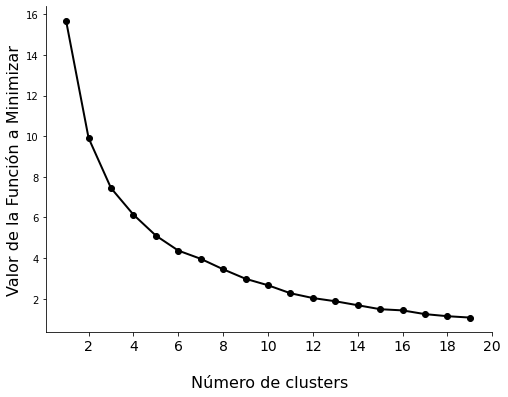

In [392]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(range(1,20), wcss, color = 'k', linewidth = 2, marker = 'o')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('\nNúmero de clusters', fontsize = 16)
ax.set_ylabel('Valor de la Función a Minimizar', fontsize = 16)
ax.set_xticks(range(2, 21, 2))
ax.set_xticklabels(range(2, 21, 2), fontsize = 14)

plt.show()

In [407]:
kmeans = KMeans(n_clusters=6, max_iter=300)
kmeans.fit(scaled_df);

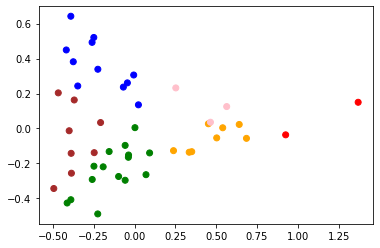

In [408]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data = pca_data, columns = ['c1', 'c2'])
pca_df['region'] = kmeans.labels_

colors = np.array(['red', 'green', 'blue', 'orange', 'brown', 'pink', 'cyan', 'k'])
plt.scatter(pca_df['c1'], pca_df['c2'], c = colors[pca_df.region])

plt.show()

In [409]:
mapa_ZMVM['region'] = kmeans.labels_
regiones = mapa_ZMVM.dissolve(by="region")

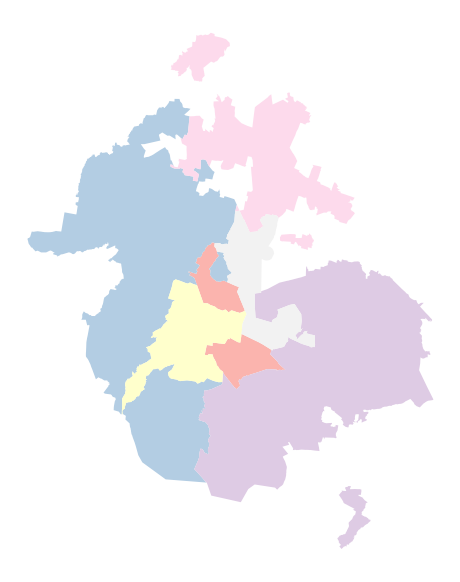

In [410]:
fig, ax = plt.subplots(figsize = (8, 12))

regiones.plot(cmap = 'Pastel1', ax = ax, legend = True)
ax.axis('off')

plt.show()

In [411]:
mapa_ZMVM.to_file('D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/regionesmap/regiones.shp')

In [412]:
df = pd.DataFrame({'cve_umun': mapa_ZMVM['cve_umun'], 'region': mapa_ZMVM['region']})

In [413]:
df.head()

,cve_umun,region
0,09012,1
1,09013,2
2,09008,1
3,09015,3
4,09010,3


In [414]:
df.to_csv('D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/transformeddata/regiones.csv',
         index=False,  encoding = 'utf-8')